# Data 

Data is available here: 

https://data.townofcary.org/explore/dataset/cpd-incidents/information/?disjunctive.crime_category&disjunctive.crime_type&disjunctive.crimeday&disjunctive.district&disjunctive.offensecategory&disjunctive.violentproperty&disjunctive.total_incidents

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [2]:
carry = pd.read_csv('D:/Projects/Crim_viz/town_of_carry2.csv', sep=';', 
                    dtype={'Beat_Number':str, 'Neighborhd_ID':str})

In [3]:
# Aim for date and time together in single datetime

colselect = ['newdate', 'From_Time', 'Lat', 'Lon',\
            'OffenseCategory', 'ViolentProperty', 'domestic', \
            'Total_Incidents']

colnames = ['Date', 'Time', 'Lat', 'Lon', 'Cat', \
            'VP', 'Domestic', 'Tot_Inc']

df = carry[colselect]
df.columns = colnames

df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.loc['2000-01-01':] #'2020-12-31']
df.head()

,Time,Lat,Lon,Cat,VP,Domestic,Tot_Inc
Date,,,,,,,
2000-09-22,02:00:00,NaN,NaN,Aggravated Assault,Part I,N,1
2001-03-03,21:00:00,35.882346,-78.802621,Aggravated Assault,Part I,N,1
2001-10-15,22:15:00,35.851336,-78.795930,Aggravated Assault,Part I,N,1
2004-09-26,02:30:00,35.810770,-78.787722,Aggravated Assault,Part I,N,1
2005-11-26,15:20:00,35.813818,-78.785873,Aggravated Assault,Part I,Y,1


# Time Series Analysis 

In [4]:
ts = df[['Tot_Inc']]
ts.head()

,Tot_Inc
Date,
2000-09-22,1
2001-03-03,1
2001-10-15,1
2004-09-26,1
2005-11-26,1


In [5]:
def by_select(by='Year', last=0, dif=False):    
    data = ts.resample(by[0]).sum()[-last:]
    data = [data.diff()[1:] if dif else data][0]
    pre = ['Difference of ' if dif else ''][0]
    return data, pre

def ts_plot(by='Year', last=0, lwd=1.5, dif=False):

    data, pre = by_select(by, last, dif)
    
    data.plot(kind='line', figsize=(10, 2), color='k', 
              legend=False, fontsize=15, linewidth=lwd)
        
    plt.title(pre + 'Number of Crimes Aggrigated by {}'.format(by), 
              fontsize=20)
    plt.ylabel(pre + 'Number of Crimes', fontsize=15)
    plt.xlabel('Time Period', fontsize=15)
    plt.show()

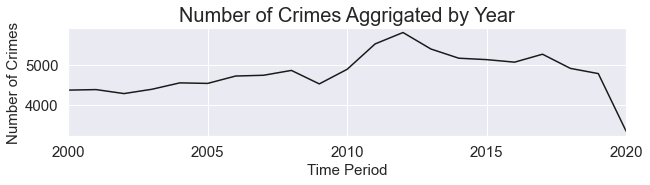

In [6]:
ts_plot()

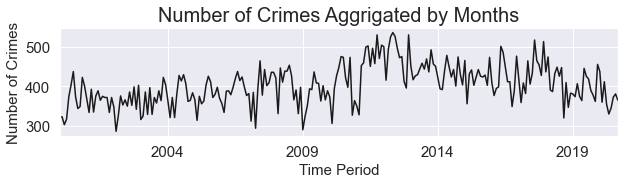

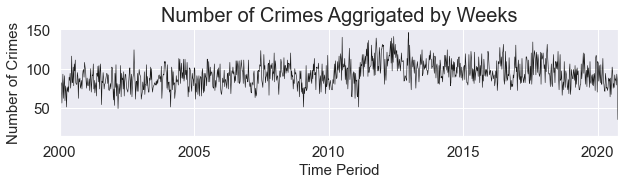

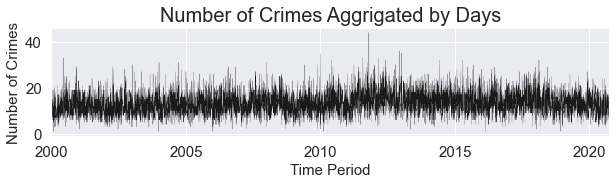

In [7]:
ts_plot('Months')
ts_plot('Weeks', lwd=0.6)
ts_plot('Days', lwd=0.2)

# Time Series Model 

In [9]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [10]:
ts_w = ts.resample('W').sum()
ts_m = ts.resample('M').sum()
ts_w.head()

,Tot_Inc
Date,
2000-01-02,20
2000-01-09,76
2000-01-16,79
2000-01-23,82
2000-01-30,56


### SARIMAX model 

- There seems to be no auto sarima
- There are 7 parameters p, d, q, P, D, Q, s. They can be anything. May be write a for loop to find the optimal value. 

In [13]:
model = SARIMAX(ts_m, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
sarima_model = model.fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Tot_Inc   No. Observations:                  249
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1188.311
Date:                            Thu, 15 Oct 2020   AIC                           2382.623
Time:                                    11:26:57   BIC                           2393.014
Sample:                                01-31-2000   HQIC                          2386.812
                                     - 09-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6819      0.047    -14.492      0.000      -0.774      -0.590
ma.S.L12      -0.8849      0.060    -14.760      0.000      -1.002      -0.767
sigma2      1277.6397    115.244     11.086      0.000    1051.766    1503.513
===================================================================================
Ljung-Box (Q):                       37.88   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.57   Prob(JB):                         0.50
Heteroskedasticity (H):               1.64   Skew:                            -0.17
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Holt-Winters

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

[]

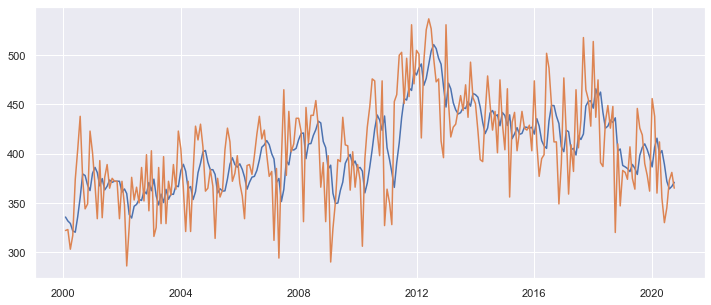

In [40]:
fhw = ExponentialSmoothing(ts_m).fit()
forecast = fhw.predict(start=0, end=-1)


In [141]:
def pred_plot(model_name, by='Month', last=0, dif=False, title='',
              start=0, end=-1, alpha=1, ylim=None):
    
    data, pre = by_select(by, last, dif)
    pred = model_name.predict(typ='levels', end=end)
    
    fhw = ExponentialSmoothing(ts_m).fit()
    forecast = fhw.predict(start=0, end=-1)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(data[start:], color='tab:gray', linewidth=0.7, alpha=alpha)
    ax.plot(pred[start:], color='tab:blue', linestyle='-', linewidth=1.5, alpha=1)
    ax.plot(forecast, 'tab:red')
    ax.set_ylim(ylim)

    obs = mpl.patches.Patch(color='tab:gray', label='Observed')
    pds = mpl.patches.Patch(color='tab:blue', label='SARIMA')
    frst = mpl.patches.Patch(color='tab:red', label='Holt-Winters')
    plt.legend(handles=[obs, pds, frst], loc=4)

    plt.title('Forecasting the Crimes'.format(str(title), by), 
              fontsize=20)
    plt.ylabel('Number of Crimes', fontsize=15)
    plt.xlabel('Year', fontsize=15)
    plt.show()

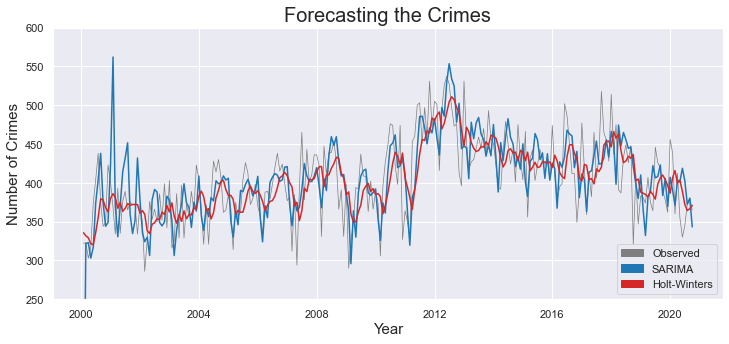

In [142]:
pred_plot(sarima_model, title='SARIMAX(0, 1, 1, 0, 1, 1, 12)', 
          alpha=1, ylim=[250, 600])